In [132]:
import numpy as np
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

In [133]:
timecalc = 9

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [134]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [135]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

In [136]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

In [137]:
# print all shapes
# print("nucleosomes[0].traj.shape", nucleosomes[0].traj.shape)
# print("nucleosomes[0].traj[0] : ", nucleosomes[0].traj[0])

# print all in and out times
# for n in nucleosomes:
#     print("nucleosome {} : in_time = {}, out_time = {}".format(n.p_ind, n.in_time, n.out_time))

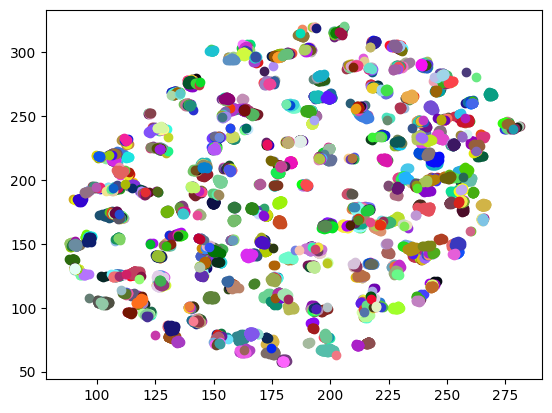

In [138]:
# plot all trajectories with different colors for each nucleosome based on p_ind
for n in nucleosomes:
    color = np.random.rand(3,)
    plt.scatter(n.traj[:, 1], n.traj[:, 2], color=color)

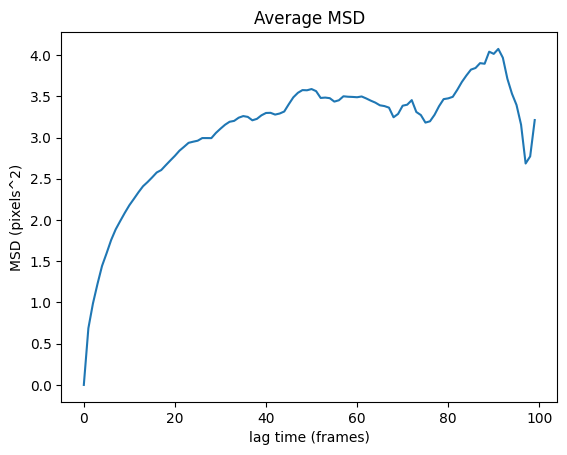

In [139]:
# calculate average MSD for each lag time 

num_frames = int(max(data[:, 1]))
if min(data[:, 1]) == 0:
    num_frames += 1

msd = np.zeros(num_frames)
msd_count = np.zeros(num_frames)

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        # print(n.traj[i,0])
        msd[i] += np.sum((n.traj[i:, 1:3] - n.traj[0:-i, 1:3])**2)
        msd_count[i] += n.traj.shape[0] - i

# average
msd[0] = 0
msd_count[0] = 1
msd = msd / msd_count
# print(msd)

# plot
plt.plot(msd)
plt.xlabel("lag time (frames)")
plt.ylabel("MSD (pixels^2)")
plt.title("Average MSD")
plt.show()

# save
np.savetxt("msd.txt", msd)


In [140]:
# calculate self part of van Hove function for each lag time
r_vals = np.arange(0, 10, 0.05)
r_bins = np.arange(0,len(r_vals), 1)
# print(r_bins)
van_hove = np.zeros((num_frames, r_bins.shape[0]-1))

for n in nucleosomes:
    for i in range(1, n.traj.shape[0]):
        # vectorized
        dist = np.linalg.norm(n.traj[i:, 1:3] - n.traj[0:-i, 1:3], axis=1)
        # scale dist to same scale as r_bins
        dist = dist * (r_bins[-1] / r_vals[-1])
        hist, _ = np.histogram(dist, bins=r_bins)
        van_hove[i, :] += hist

# average
van_hove = van_hove / len(nucleosomes)

# print(van_hove.shape)

# save 
np.savetxt("van_hove.txt", van_hove)



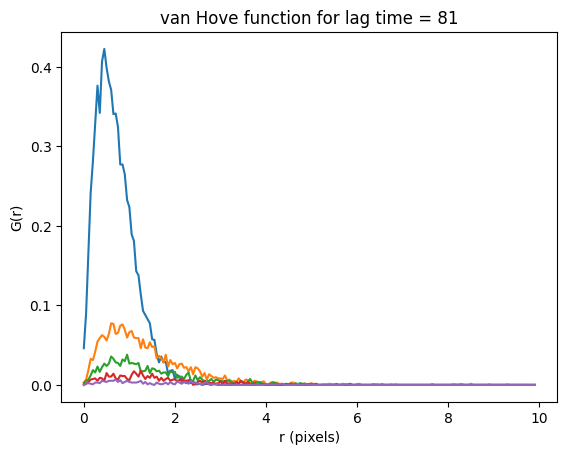

In [142]:
# plot van Hove function for lag time = i
# i = 50
for i in range(1, num_frames, 20):
    plt.plot(r_vals[:-1], van_hove[i, :])
    plt.xlabel("r (pixels)")
    plt.ylabel("G(r)")
    plt.title(f"van Hove function for lag time = {i}")
    # plt.show()

In [ ]:
# gaussian
